--- INICIANDO BACKTESTING (FASE 5) ---
Carregando modelo treinado...
Realizando previsões em 70 dias desconhecidos...

RELATÓRIO DE PERFORMANCE
Erro Médio Absoluto (MAE): $2490.60
Raiz do Erro Quadrático Médio (RMSE): $2960.14
----------------------------------------
Isso significa que o modelo erra, em média, $2490.60 para cima ou para baixo.
Maior erro registrado: $6486.12 no dia 15/11/2025


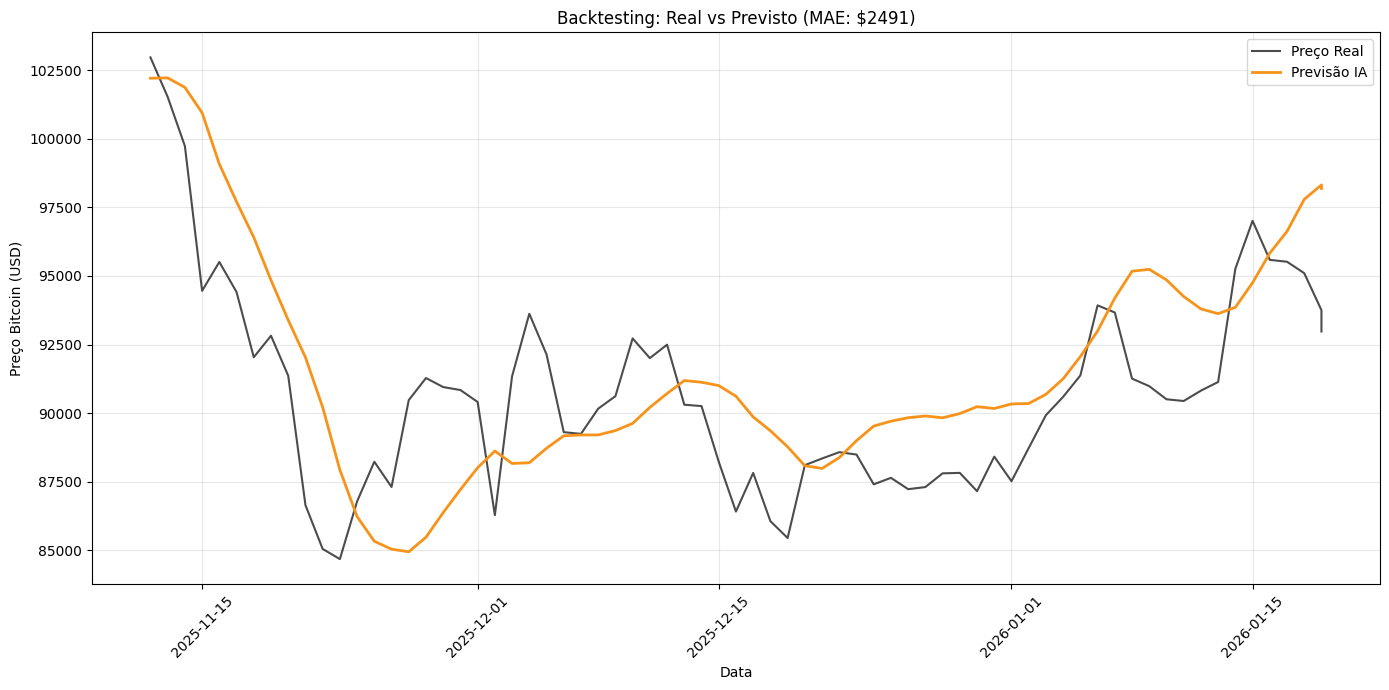

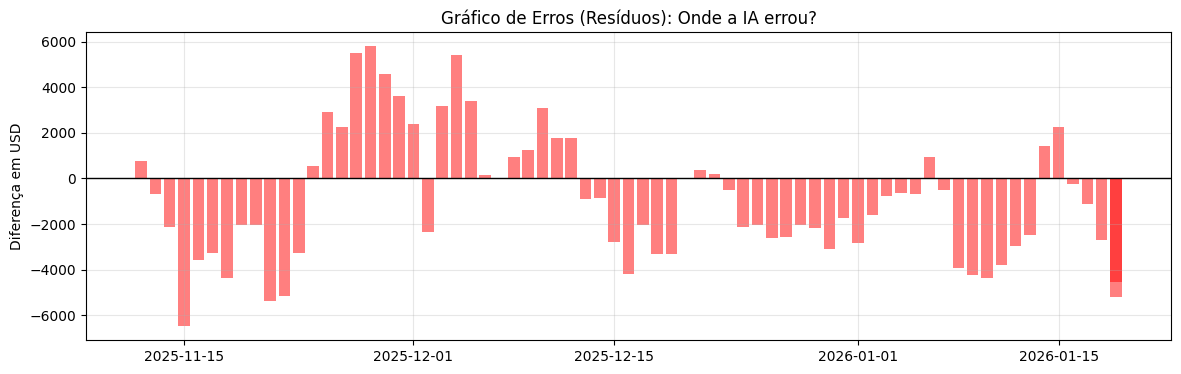

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

def backtesting_rigoroso():
    print("--- INICIANDO BACKTESTING (FASE 5) ---")

    # 1. CARREGAR DADOS
    # Precisamos recriar o ambiente exato do treino
    try:
        df = pd.read_csv('dataset_consolidado.csv', sep=';', decimal=',', index_col='Data')
        df.index = pd.to_datetime(df.index) # Garantir que o índice é data
    except FileNotFoundError:
        print("Erro: 'dataset_consolidado.csv' não encontrado.")
        return

    # Features usadas (Mesma ordem do treino)
    features = ['Preco_Fechamento', 'Volume', 'SMA_7', 'SMA_21', 'RSI', 'Sentimento_Medio']
    data = df[features].values

    # Normalizar
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # 2. SEPARAR O CONJUNTO DE TESTE (Blind Test)
    # O modelo NUNCA viu estes dados durante o treino.
    janela = 60
    tamanho_treino = int(len(data_scaled) * 0.8)

    # Pegamos os dados de teste (com a janela de 60 dias antes para poder prever o primeiro dia de teste)
    dados_teste_com_janela = data_scaled[tamanho_treino - janela:]

    X_test = []
    y_test_real = []

    for i in range(janela, len(dados_teste_com_janela)):
        X_test.append(dados_teste_com_janela[i-janela:i])
        y_test_real.append(dados_teste_com_janela[i, 0]) # Coluna 0 é o Preço

    X_test, y_test_real = np.array(X_test), np.array(y_test_real)

    # 3. CARREGAR O MODELO E PREVER
    print("Carregando modelo treinado...")
    model = load_model('modelo_cripto.keras')

    print(f"Realizando previsões em {len(X_test)} dias desconhecidos...")
    previsoes_scaled = model.predict(X_test, verbose=0)

    # 4. DESNORMALIZAR (VOLTAR PARA DÓLARES)
    # Truque para usar o inverse_transform que espera 6 colunas
    def desnormalizar(lista_valores, scaler):
        matriz_aux = np.zeros((len(lista_valores), 6))
        matriz_aux[:, 0] = lista_valores
        return scaler.inverse_transform(matriz_aux)[:, 0]

    y_real_usd = desnormalizar(y_test_real, scaler)
    y_prev_usd = desnormalizar(previsoes_scaled.flatten(), scaler)

    # Recuperar as datas correspondentes para o gráfico ficar bonito
    datas_teste = df.index[tamanho_treino:]

    # 5. CÁLCULO DE MÉTRICAS (Exigência do PDF: MAE e RMSE)
    mae = mean_absolute_error(y_real_usd, y_prev_usd)
    rmse = np.sqrt(mean_squared_error(y_real_usd, y_prev_usd))

    print("\n" + "="*40)
    print("RELATÓRIO DE PERFORMANCE")
    print("="*40)
    print(f"Erro Médio Absoluto (MAE): ${mae:.2f}")
    print(f"Raiz do Erro Quadrático Médio (RMSE): ${rmse:.2f}")
    print("-" * 40)
    print(f"Isso significa que o modelo erra, em média, ${mae:.2f} para cima ou para baixo.")

    # 6. ANÁLISE DE ERROS (Onde ele errou mais?)
    erros = np.abs(y_real_usd - y_prev_usd)
    pior_dia_idx = np.argmax(erros)
    pior_erro = erros[pior_dia_idx]
    pior_dia_data = datas_teste[pior_dia_idx].strftime('%d/%m/%Y')

    print(f"Maior erro registrado: ${pior_erro:.2f} no dia {pior_dia_data}")
    print("="*40)

    # 7. VISUALIZAÇÃO DE RESULTADOS
    plt.figure(figsize=(14, 7))
    plt.plot(datas_teste, y_real_usd, color='black', label='Preço Real', alpha=0.7)
    plt.plot(datas_teste, y_prev_usd, color='#f7931a', label='Previsão IA', linewidth=2) # Laranja Bitcoin

    plt.title(f'Backtesting: Real vs Previsto (MAE: ${mae:.0f})')
    plt.xlabel('Data')
    plt.ylabel('Preço Bitcoin (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # GRÁFICO EXTRA: Resíduos (Para impressionar o professor)
    # Mostra se o erro é aleatório ou se tem padrão
    plt.figure(figsize=(14, 4))
    plt.bar(datas_teste, y_real_usd - y_prev_usd, color='red', alpha=0.5)
    plt.title('Gráfico de Erros (Resíduos): Onde a IA errou?')
    plt.axhline(0, color='black', linewidth=1)
    plt.ylabel('Diferença em USD')
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    backtesting_rigoroso()